In [1]:
import numpy as np
import h5py as h5

import matplotlib.pyplot as plt

In [2]:
h5f = '/home3/ivkhar/TA/data/MC/bundled/pr_q3_14yr_1745_0010_excl_sat_T_excl_geo_T_bundled.h5'

In [3]:
num = 64

with h5.File(h5f,'r') as hf:
    times_flat = hf['dt_bunlde'][:num,:,:,4:5].astype(np.float64) # in mks
    times_diff = hf['dt_bunlde'][:num,:,:,5:6].astype(np.float64) # in mks
    mask_in = hf['dt_bunlde'][:num,:,:,6:7].astype(np.float64)
    real_coords = hf['dt_bunlde'][:num,:,:,:3].astype(np.float64)*1.2 # in km
    qs_in = hf['dt_bunlde'][:num,:,:,3:4].astype(np.float64)
    ev_params = hf['recos'][:num,[0,1,2,6]].astype(np.float64) # theta, phi, S_800, a_linsley
    
mask_qs = np.where( np.logical_and(mask_in>0, qs_in>0), 1., 0. )

In [4]:
# set c=1, time in mks, distance in km
time2dist = np.array([0.299792458], dtype=np.float64)

times_flat *= time2dist
times_diff *= time2dist

times_reg = times_flat + times_diff

In [5]:
theta_rub = ev_params[:num,0]/180*3.1415
phi_rub = ev_params[:num,1]/180*3.1415

In [6]:
# "-" in nz seems to be correct, by comparison
nx = - np.sin(theta_rub)[:,np.newaxis,np.newaxis] * np.cos(phi_rub)[:,np.newaxis,np.newaxis]
ny = - np.sin(theta_rub)[:,np.newaxis,np.newaxis] * np.sin(phi_rub)[:,np.newaxis,np.newaxis]
nz = - np.cos(theta_rub)[:,np.newaxis,np.newaxis]
a = np.concatenate((nx,ny,nz), axis=-1)
a = np.expand_dims( a, axis=1 )

t_rec_flat = np.sum( a*real_coords[:,:,:,:3], axis=-1 )
t_rec_flat = t_rec_flat*mask_in[:,:,:,0]

In [7]:
diff = np.abs(t_rec_flat - times_flat[:,:,:,0])
print(np.amax(diff))
print(diff[:3])

0.000269645394991358
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.06417376e-04
   1.66653433e-04 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.09234888e-04 3.30225084e-05
   1.04924472e-05 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 5.78108483e-05 1.19184368e-04
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 2.07729249e-04 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.08587873e-04 1.12594804e-04
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 9.52953402e-06 6.65264029e-05
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.27388240e-04 1.20785371e-04
   0.00000000e+00 0.00000000e+00]
  [0.00

In [8]:
a_rub = ev_params[:,3,np.newaxis,np.newaxis]
s_800_rub = ev_params[:,2,np.newaxis,np.newaxis]

theta_rub = ev_params[:num,0,np.newaxis,np.newaxis]/180*3.1415
phi_rub = ev_params[:num,1,np.newaxis,np.newaxis]/180*3.1415

In [9]:
def get_eta(theta):
    
    x = theta*180.0/3.1415
    
    e1 = 3.97 - 1.79*(np.abs(1.0/(np.abs(np.cos(theta))+1e-6)) - 1.0)
    e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
               + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
             + 3.70692527e+00)
    res = np.where(x<62.7,e1,e2)  
    
    return res

In [10]:
Rm = np.array([0.09])
R1 = np.array([1.])

def get_profile(r, eta):

    res = np.power(((r+1e-6)/Rm),-1.2) * np.power((1+r/Rm), -(eta-1.2)) * np.power(1.+r*r/R1/R1,-0.6)
    return res

In [11]:
# depending on def of a (linsley, prime), may or may not include S_800
# check fo 0.67
def get_lins_t(r):
    return 0.67*np.power((1 + r/R_L), 1.5)

In [12]:
# check dimensions in error calc
t0_err = 0.03*time2dist

def get_linsley_s(r, S):
    return 1.3*0.29*np.power((1 + r/R_L), 1.5)*np.power(S+1e-8, -0.3)

In [29]:
R_800 = np.array([0.8])
R_L = 0.03

# "-" in projection
def get_exp_time(theta, phi, coords, t_flat, aprime, mask, S_800):
    # get distance to shower core
    proj_to_n = np.sin(theta)*( np.cos(phi)*coords[:,:,:,0] + np.sin(phi)*coords[:,:,:,1] ) + np.cos(theta)*coords[:,:,:,2]
    dist_core = np.sum( np.power(coords,2), axis=(3) ) - np.power(proj_to_n,2)
    dist_core = np.where( dist_core>0, np.sqrt( dist_core ), 0. )
    # get eta
    eta = get_eta(theta)
    # eval time
    t_rec_curv = aprime*get_lins_t(dist_core)*np.sqrt( get_profile(R_800, eta)/get_profile(dist_core, eta) )*1e-3#*time2dist
    # get error
    s_r = get_profile(dist_core, eta)
    s_8 = get_profile(0.8, eta)
    lin_s = get_linsley_s(dist_core, S_800*s_r/s_8 )
    t_s = aprime*np.sqrt(S_800)*lin_s*1e-3*time2dist
    return t_rec_curv*mask, np.sqrt((t0_err*t0_err + t_s*t_s))*mask

In [30]:
t_rec_curv, t_err = get_exp_time(theta_rub, phi_rub, real_coords, t_rec_flat, a_rub, mask_qs[...,0], s_800_rub)

In [31]:
t_rec_curv[:5]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.66531877, 1.42105741,
         0.        ],
        [0.        , 0.        , 0.11083598, 0.01273881, 0.39016623,
         0.        ],
        [0.        , 0.        , 0.14790388, 0.09912458, 0.        ,
         0.        ],
        [0.        , 0.        , 1.6589407 , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.52461433, 0.62159757, 0.        ,
         0.        ],
        [0.        , 0.        , 0.03793497, 0.05694821, 0.        ,
         0.        ],
        [0.        , 0.        , 0.0824514 , 0.10833645, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.86654023, 0.        ,
         0.        

In [33]:
times_diff[:5,:,:,0]/time2dist

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 1.28600001, 2.09800005,
         0.        ],
        [0.        , 0.        , 0.48699999, 0.28799999, 0.73400003,
         0.        ],
        [0.        , 0.        , 0.39700001, 0.49000001, 0.        ,
         0.        ],
        [0.        , 0.        , 0.583     , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 1.02199996, 0.829     , 0.        ,
         0.        ],
        [0.        , 0.        , 0.35800001, 0.36700001, 0.        ,
         0.        ],
        [0.        , 0.        , 0.38699999, 0.44800001, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 1.07099998, 0.        ,
         0.        

In [15]:
print(t_rec_curv[:5]-times_diff[:5,:,:,0])

[[[ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.         -0.18607556 -0.2029423
    0.        ]
  [ 0.          0.         -0.11277113 -0.08252122 -0.10307878
    0.        ]
  [ 0.          0.         -0.07467714 -0.1171815   0.
    0.        ]
  [ 0.          0.          0.3225589   0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.         -0.14911246 -0.06217768  0.
    0.        ]
  [ 0.          0.         -0.09595308 -0.09295119  0.
    0.        ]
  [ 0.          0.         -0.09130137 -0.10182857  0.
    0.        ]
  [ 0.          0.          0.         -0.06129549  0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
   

In [16]:
print(t_err[:5])

[[[0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.09485107 0.16898325 0.        ]
  [0.         0.         0.02538918 0.01000844 0.06333273 0.        ]
  [0.         0.         0.03101496 0.0235589  0.         0.        ]
  [0.         0.         0.19012651 0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.0777361  0.08836037 0.         0.        ]
  [0.         0.         0.01360323 0.01662915 0.         0.        ]
  [0.         0.         0.0206828  0.0246926  0.         0.        ]
  [0.         0.         0.         0.11363068 0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.

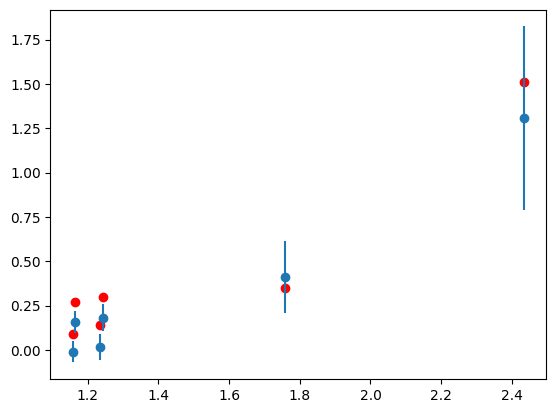

In [17]:
n_ev = 8
mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev]+t_rec_flat[n_ev])[mask]
ts = times_reg[n_ev][mask]
errs = t_err[n_ev][mask]

#fig, ax = plt.subplots()
plt.scatter(xs, ts, c='red')
plt.errorbar(xs, ys, yerr=errs, fmt='o')
plt.show()

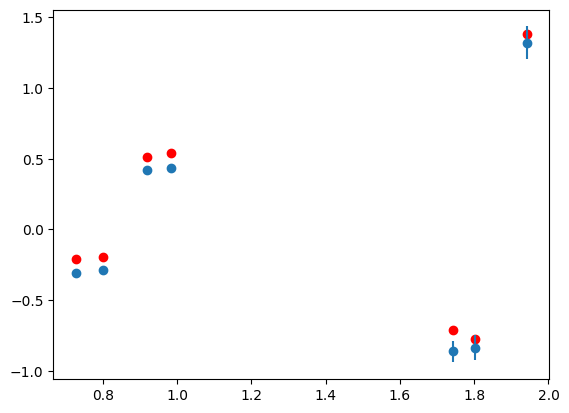

In [18]:
n_ev = 1
mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev]+t_rec_flat[n_ev])[mask]
ts = times_reg[n_ev][mask]
errs = t_err[n_ev][mask]

#fig, ax = plt.subplots()
plt.scatter(xs, ts, c='red')
plt.errorbar(xs, ys, yerr=errs, fmt='o')
plt.show()

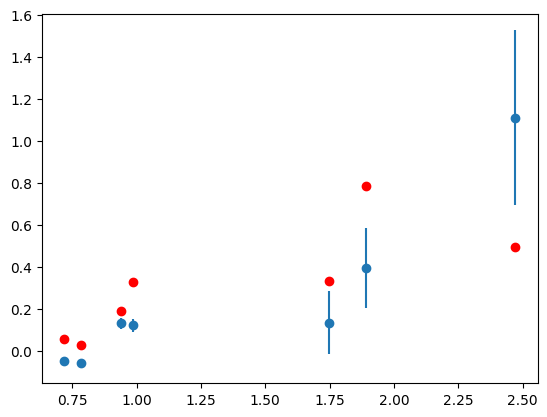

In [19]:
n_ev = 2
mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev]+t_rec_flat[n_ev])[mask]
ts = times_reg[n_ev][mask]
errs = t_err[n_ev][mask]

#fig, ax = plt.subplots()
plt.scatter(xs, ts, c='red')
plt.errorbar(xs, ys, yerr=errs, fmt='o')
plt.show()

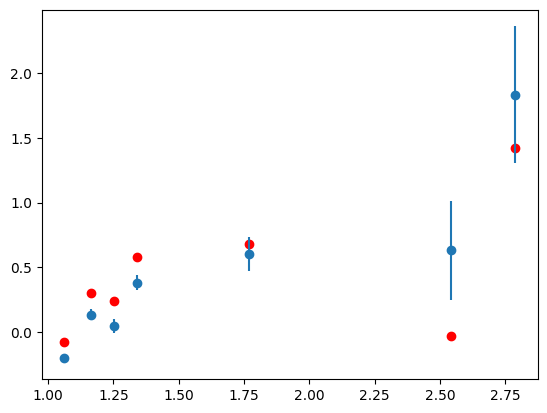

In [20]:
n_ev = 45
mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev]+t_rec_flat[n_ev])[mask]
ts = times_reg[n_ev][mask]
errs = t_err[n_ev][mask]

#fig, ax = plt.subplots()
plt.scatter(xs, ts, c='red')
plt.errorbar(xs, ys, yerr=errs, fmt='o')
plt.show()